In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
# from einops import rearrange, reduce, repeat
# from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

In [2]:
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

In [9]:
vit_b_16 = models.vit_b_16(pretrained=True)

In [5]:
transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.functional.InterpolationMode('bicubic')),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])

In [6]:
with open("imagenet1000_clsidx_to_labels.txt") as f:
    idx2label = eval(f.read())

idx is 285
test result class is  Egyptian cat


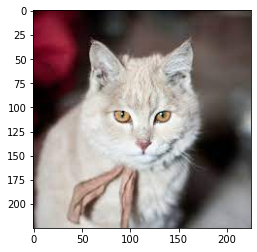

In [10]:
test_img('images/cat.jpg',vit_b_16)

In [3]:
import timm
from timm.models import vision_transformer
from timm.models.vision_transformer import Attention
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD, IMAGENET_INCEPTION_MEAN, IMAGENET_INCEPTION_STD
from types import MethodType
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

In [4]:
def test_img(img_path,vit):
    img = Image.open(img_path)
    fig = plt.figure()
    plt.imshow(img)
    vit.eval()
    config = resolve_data_config({}, model=vit)
    print(config)
    test_transform = create_transform(**config)
    img = test_transform(img)[None,]
    output = vit(img)
    # print(output.shape)
    # print('sum of output',torch.sum(output,dim=-1))
    # print(output)
    idx = torch.argmax(output).item()
    print('idx is',idx)
    print('test result class is ',idx2label[idx])

In [4]:
def attention_forward(self, x):
    B, N, C = x.shape
    qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
    q, k, v = qkv.unbind(0)   # make torchscript happy (cannot use tensor as tuple)

    # attn = (q @ k.transpose(-2, -1)) * self.scale
    attn = self.matmul1(q, k.transpose(-2, -1)) * self.scale
    attn = attn.softmax(dim=-1)
    attn = self.attn_drop(attn)
    del q, k

    # x = (attn @ v).transpose(1, 2).reshape(B, N, C)
    x = self.matmul2(attn, v).transpose(1, 2).reshape(B, N, C)
    del attn, v
    x = self.proj(x)
    x = self.proj_drop(x)
    return x

In [11]:
class MatMul(nn.Module):
    def forward(self, A, B):
        return A @ B

{'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'crop_pct': 0.9}
idx is 1
test result class is  goldfish, Carassius auratus


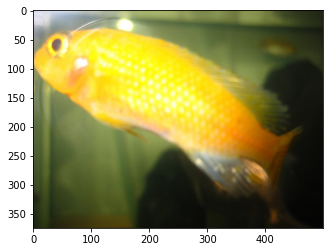

In [74]:
net = timm.create_model('vit_tiny_patch16_224', pretrained=True)
test_img('data/imagenet/val/n01443537/ILSVRC2012_val_00003150.JPEG',net)

{'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'crop_pct': 0.9}
idx is 1
test result class is  goldfish, Carassius auratus


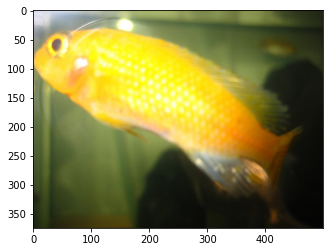

In [8]:
net = timm.create_model('deit_base_patch16_224', pretrained=True)
test_img('data/imagenet/val/n01443537/ILSVRC2012_val_00003150.JPEG',net)

In [ ]:
net = timm.create_model('vit_base_patch16_224', pretrained=True)
for name,module in net.named_modules():
    if isinstance(module, Attention):
        setattr(module, "matmul1", MatMul())
        setattr(module, "matmul2", MatMul())
        module.forward = MethodType(attention_forward, module)
# net.cuda()
net.eval()

In [58]:
def wrap_modules_in_net(net,cfg):
    wrapped_modules={}
    module_dict={}
    module_types = {"qkv":"qlinear_qkv", "proj":'qlinear_proj', 'fc1':'qlinear_MLP_1', 'fc2':"qlinear_MLP_2", 'head':'qlinear_classifier','matmul1':"qmatmul_qk", 'matmul2':"qmatmul_scorev", "reduction": "qlinear_reduction"}
    
    it=[(name,m) for name,m in net.named_modules()]
    for name,m in it:
        module_dict[name]=m
        idx=name.rfind('.')
        if idx==-1:
            idx=0
        father_name=name[:idx]
        if father_name in module_dict:
            father_module=module_dict[father_name]
            print('father name:',father_name)
        else:
            raise RuntimeError(f"father module {father_name} not found")
        if isinstance(m,nn.Conv2d):
            # Embedding Layer
            idx = idx+1 if idx != 0 else idx
            new_m=cfg.get_module("qconv",m.in_channels,m.out_channels,m.kernel_size,m.stride,m.padding,m.dilation,m.groups,m.bias is not None,m.padding_mode)
            new_m.weight.data=m.weight.data
            new_m.bias=m.bias
            replace_m=new_m
            wrapped_modules[name] = new_m
            setattr(father_module,name[idx:],replace_m)
        elif isinstance(m,nn.Linear):
            # Linear Layer
            idx = idx+1 if idx != 0 else idx
            new_m = cfg.get_module(module_types[name[idx:]],m.in_features,m.out_features)
            new_m.weight.data=m.weight.data
            new_m.bias=m.bias
            replace_m=new_m
            wrapped_modules[name] = new_m
            print('name[idx]',name[idx:])
            setattr(father_module,name[idx:],replace_m)
        elif isinstance(m,MatMul):
            # Matmul Layer
            idx = idx+1 if idx != 0 else idx
            new_m = cfg.get_module(module_types[name[idx:]])
            replace_m=new_m
            wrapped_modules[name] = new_m
            setattr(father_module,name[idx:],replace_m)
    print("Completed net wrap.")
    return wrapped_modules

In [16]:
import os
from importlib import reload,import_module
import datasets
from quant_calib import HessianQuantCalibrator
from tqdm import tqdm

In [17]:
def init_config(config_name):
    """initialize the config. Use reload to make sure it's fresh one!"""
    _,_,files =  next(os.walk("./configs"))
    if config_name+".py" in files:
        quant_cfg = import_module(f"configs.{config_name}")
    else:
        raise NotImplementedError(f"Invalid config name {config_name}")
    reload(quant_cfg)
    return quant_cfg

In [18]:
def test_classification(net,test_loader,max_iteration=None, description=None):
    pos=0
    tot=0
    i = 0
    max_iteration = len(test_loader) if max_iteration is None else max_iteration
    with torch.no_grad():
        q=tqdm(test_loader, desc=description)
        for inp,target in q:
            i+=1
            inp=inp.cuda()
            target=target.cuda()
            out=net(inp)
            pos_num=torch.sum(out.argmax(1)==target).item()
            pos+=pos_num
            tot+=inp.size(0)
            q.set_postfix({"acc":pos/tot})
            if i >= max_iteration:
                break
    print(pos/tot)
    return pos/tot

In [20]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('model size: {:.3f}MB'.format(size_all_mb))

In [16]:
def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

In [23]:
print_model_size(net)

22.92 MB


In [54]:
for name,m in net.named_modules():
    print(name)


patch_embed
patch_embed.proj
patch_embed.norm
pos_drop
blocks
blocks.0
blocks.0.norm1
blocks.0.attn
blocks.0.attn.qkv
blocks.0.attn.attn_drop
blocks.0.attn.proj
blocks.0.attn.proj_drop
blocks.0.attn.matmul1
blocks.0.attn.matmul2
blocks.0.drop_path
blocks.0.norm2
blocks.0.mlp
blocks.0.mlp.fc1
blocks.0.mlp.act
blocks.0.mlp.drop1
blocks.0.mlp.fc2
blocks.0.mlp.drop2
blocks.1
blocks.1.norm1
blocks.1.attn
blocks.1.attn.qkv
blocks.1.attn.attn_drop
blocks.1.attn.proj
blocks.1.attn.proj_drop
blocks.1.attn.matmul1
blocks.1.attn.matmul2
blocks.1.drop_path
blocks.1.norm2
blocks.1.mlp
blocks.1.mlp.fc1
blocks.1.mlp.act
blocks.1.mlp.drop1
blocks.1.mlp.fc2
blocks.1.mlp.drop2
blocks.2
blocks.2.norm1
blocks.2.attn
blocks.2.attn.qkv
blocks.2.attn.attn_drop
blocks.2.attn.proj
blocks.2.attn.proj_drop
blocks.2.attn.matmul1
blocks.2.attn.matmul2
blocks.2.drop_path
blocks.2.norm2
blocks.2.mlp
blocks.2.mlp.fc1
blocks.2.mlp.act
blocks.2.mlp.drop1
blocks.2.mlp.fc2
blocks.2.mlp.drop2
blocks.3
blocks.3.norm1
bloc

In [59]:
quant_cfg = init_config("PTQ4ViT")
wrapped_modules = wrap_modules_in_net(net,quant_cfg)

g=datasets.ViTImageNetLoaderGenerator('./data/imagenet','imagenet',32,32,16,kwargs={"model":net})


father name: 
father name: 
father name: patch_embed
father name: patch_embed
father name: 
father name: 
father name: blocks
father name: blocks.0
father name: blocks.0
father name: blocks.0.attn
name[idx] qkv
father name: blocks.0.attn
father name: blocks.0.attn
name[idx] proj
father name: blocks.0.attn
father name: blocks.0.attn
father name: blocks.0.attn
father name: blocks.0
father name: blocks.0
father name: blocks.0
father name: blocks.0.mlp
name[idx] fc1
father name: blocks.0.mlp
father name: blocks.0.mlp
father name: blocks.0.mlp
name[idx] fc2
father name: blocks.0.mlp
father name: blocks
father name: blocks.1
father name: blocks.1
father name: blocks.1.attn
name[idx] qkv
father name: blocks.1.attn
father name: blocks.1.attn
name[idx] proj
father name: blocks.1.attn
father name: blocks.1.attn
father name: blocks.1.attn
father name: blocks.1
father name: blocks.1
father name: blocks.1
father name: blocks.1.mlp
name[idx] fc1
father name: blocks.1.mlp
father name: blocks.1.mlp
fa

In [60]:
net

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): ChannelwiseBatchingQuantConv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): PTQSLBatchingQuantLinear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): PTQSLBatchingQuantLinear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
        (matmul1): PTQSLBatchingQuantMatMul()
        (matmul2): SoSPTQSLBatchingQuantMatMul()
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): PTQSLBatchingQuantLinear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
     

In [32]:
wrapped_modules

{'patch_embed.proj': ChannelwiseBatchingQuantConv2d(3, 768, kernel_size=(16, 16), stride=(16, 16)),
 'blocks.0.attn.qkv': PTQSLBatchingQuantLinear(in_features=768, out_features=2304, bias=True),
 'blocks.0.attn.proj': PTQSLBatchingQuantLinear(in_features=768, out_features=768, bias=True),
 'blocks.0.attn.matmul1': PTQSLBatchingQuantMatMul(),
 'blocks.0.attn.matmul2': SoSPTQSLBatchingQuantMatMul(),
 'blocks.0.mlp.fc1': PTQSLBatchingQuantLinear(in_features=768, out_features=3072, bias=True),
 'blocks.0.mlp.fc2': PostGeluPTQSLBatchingQuantLinear(in_features=3072, out_features=768, bias=True),
 'blocks.1.attn.qkv': PTQSLBatchingQuantLinear(in_features=768, out_features=2304, bias=True),
 'blocks.1.attn.proj': PTQSLBatchingQuantLinear(in_features=768, out_features=768, bias=True),
 'blocks.1.attn.matmul1': PTQSLBatchingQuantMatMul(),
 'blocks.1.attn.matmul2': SoSPTQSLBatchingQuantMatMul(),
 'blocks.1.mlp.fc1': PTQSLBatchingQuantLinear(in_features=768, out_features=3072, bias=True),
 'blocks

In [26]:
test_loader=g.test_loader()
calib_loader=g.calib_loader(num=32)

/home/simon/.local/lib/python3.8/site-packages/torch/utils/data/dataloader.py:487: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
quant_calibrator = HessianQuantCalibrator(net,wrapped_modules,calib_loader,sequential=False,batch_size=4) # 16 is too big for ViT-L-16
quant_calibrator.batching_quant_calib()

In [109]:
test_model = timm.create_model('vit_small_patch16_224',pretrained=False)

In [ ]:
for name,_ in test_model.named_parameters():
    print(name)

In [150]:
x = torch.load('vit_small_patch16_224.pth')

In [ ]:
x.keys()

In [ ]:
for name,m in test_model.named_parameters():
    print(name)

In [ ]:
test_model.load_state_dict(torch.load('vit_small_patch16_224.pth'))

In [ ]:
model_deit = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model_deit.eval()

In [141]:
backend = "fbgemm"
model_deit.qconfig = torch.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine = backend

In [142]:
model_deit.qconfig

QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){})

In [143]:
get_model_size(model_deit)

model size: 330.229MB


In [147]:
print_model_size(model_deit)

346.32 MB


In [145]:
quantized_model = torch.quantization.quantize_dynamic(model_deit, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8)

/home/simon/.local/lib/python3.8/site-packages/torch/ao/quantization/observer.py:177: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [148]:
get_model_size(quantized_model)

model size: 2.979MB


In [149]:
print_model_size(quantized_model)

89.25 MB


In [153]:
model_deit = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
model_deit.eval()
backend = "qnnpack"
model_deit.qconfig = torch.quantization.get_default_qconfig(backend)
torch.backends.quantized.engine = backend
model_static_quantized = torch.quantization.prepare(model_deit, inplace=False)
model_static_quantized = torch.quantization.convert(model_static_quantized, inplace=False)

Using cache found in /home/simon/.cache/torch/hub/facebookresearch_deit_main
/home/simon/.local/lib/python3.8/site-packages/torch/ao/quantization/observer.py:1124: UserWarning: must run observer before calling calculate_qparams.                                    Returning default scale and zero point 
  warnings.warn(
[W TensorImpl.h:1463] Warning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (function operator())


In [154]:
print_model_size(model_static_quantized)

87.49 MB


In [65]:
net = timm.create_model('vit_base_patch16_224',pretrained=True)

In [66]:
net

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU()
        (drop1): Dropout(p=0.0, inplace=False)
        (fc2): Linear(in_features=3072, out_features=768, bias=True)
        (drop2): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((768,),

In [67]:
summary(net,input_size=(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 768, 14, 14]         590,592
          Identity-2             [-1, 196, 768]               0
        PatchEmbed-3             [-1, 196, 768]               0
           Dropout-4             [-1, 197, 768]               0
         LayerNorm-5             [-1, 197, 768]           1,536
            Linear-6            [-1, 197, 2304]       1,771,776
           Dropout-7         [-1, 12, 197, 197]               0
            Linear-8             [-1, 197, 768]         590,592
           Dropout-9             [-1, 197, 768]               0
        Attention-10             [-1, 197, 768]               0
         Identity-11             [-1, 197, 768]               0
        LayerNorm-12             [-1, 197, 768]           1,536
           Linear-13            [-1, 197, 3072]       2,362,368
             GELU-14            [-1, 19

In [62]:
a = torch.tensor([[1,2,3]],dtype=torch.int8)
b = torch.tensor([[10,100],[20,200],[30,300]],dtype=torch.int8)
c = torch.tensor([[1,2,3],[2,4,6]],dtype=torch.int8)

In [63]:
x = F.linear(a,c)

In [64]:
x

tensor([[14, 28]], dtype=torch.int8)

In [68]:
model = timm.create_model("vit_base_patch16_224",pretrained=True)
backend = "fbgemm"
model.qconfig = torch.quantization.get_default_qconfig(backend)
quantized_model = torch.quantization.quantize_dynamic(model, qconfig_spec={torch.nn.Linear,torch.nn.Conv2d}, dtype=torch.qint8)

/home/simon/.local/lib/python3.8/site-packages/torch/ao/quantization/observer.py:177: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


{'input_size': (3, 224, 224), 'interpolation': 'bicubic', 'mean': (0.5, 0.5, 0.5), 'std': (0.5, 0.5, 0.5), 'crop_pct': 0.9}
idx is 1
test result class is  goldfish, Carassius auratus


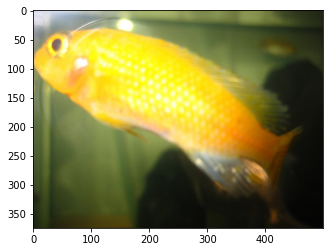

In [75]:
test_img('data/imagenet/val/n01443537/ILSVRC2012_val_00003150.JPEG',quantized_model)

In [2]:
import torch

In [13]:
a = torch.load('model_size.pt')

In [14]:
a

{'vit_tiny_patch16_224': 22.924497,
 'vit_small_patch16_224': 88.257745,
 'vit_base_patch16_224': 346.325713,
 'deit_tiny_patch16_224': 22.924497,
 'deit_small_patch16_224': 88.257745,
 'deit_base_patch16_224': 346.325713}

In [15]:
b = torch.load('test_acc.pt')

In [16]:
b

{'vit_tiny_patch16_224': 0.75458,
 'vit_small_patch16_224': 0.81392,
 'vit_base_patch16_224': 0.84528,
 'deit_tiny_patch16_224': 0.72176,
 'deit_small_patch16_224': 0.79854,
 'deit_base_patch16_224': 0.81986}

In [7]:
c= torch.load('PTQ_model_size.pt')

In [8]:
c

defaultdict(list,
            {'vit_tiny_patch16_224': [8.316687, 8.316687],
             'vit_small_patch16_224': [32.544207, 32.544207],
             'vit_base_patch16_224': [128.774607, 128.774607],
             'deit_tiny_patch16_224': [8.316687, 8.316687],
             'deit_small_patch16_224': [32.544207, 32.544207],
             'deit_base_patch16_224': [128.774607, 128.774607]})

In [9]:
c['vit_tiny_patch16_224']

[8.316687, 8.316687]

In [10]:
d = torch.load('PTQ_test_acc.pt')

In [11]:
d

defaultdict(list,
            {'vit_tiny_patch16_224': [0.69828, 0.74638],
             'vit_small_patch16_224': [0.80552, 0.80962],
             'vit_base_patch16_224': [0.83876, 0.8404],
             'deit_tiny_patch16_224': [0.7127, 0.71702],
             'deit_small_patch16_224': [0.77614, 0.794],
             'deit_base_patch16_224': [0.8093, 0.81436]})

In [17]:
b

{'vit_tiny_patch16_224': 0.75458,
 'vit_small_patch16_224': 0.81392,
 'vit_base_patch16_224': 0.84528,
 'deit_tiny_patch16_224': 0.72176,
 'deit_small_patch16_224': 0.79854,
 'deit_base_patch16_224': 0.81986}

In [31]:
x = torch.load('experimental_results/infer_time_pytorch.pt')

In [32]:
x

defaultdict(list,
            {'vit_tiny_patch16_224': [42.453, 36.024],
             'vit_small_patch16_224': [71.028, 49.882],
             'vit_base_patch16_224': [267.956, 149.743],
             'deit_tiny_patch16_224': [26.01, 22.583],
             'deit_small_patch16_224': [78.33, 47.967],
             'deit_base_patch16_224': [247.512, 150.011]})

In [22]:
y = torch.load('Pytorch_model_size.pt')

In [23]:
y

{'vit_tiny_patch16_224': 6.455053,
 'vit_small_patch16_224': 23.436621,
 'vit_base_patch16_224': 89.249613,
 'deit_tiny_patch16_224': 6.455053,
 'deit_small_patch16_224': 23.436621,
 'deit_base_patch16_224': 89.249613}

In [24]:
z = torch.load('Pytorch_test_acc.pt')

In [25]:
z

{'vit_tiny_patch16_224': 0.71516,
 'vit_small_patch16_224': 0.79826,
 'vit_base_patch16_224': 0.8367,
 'deit_tiny_patch16_224': 0.71644,
 'deit_small_patch16_224': 0.79102,
 'deit_base_patch16_224': 0.813}

In [26]:
d

defaultdict(list,
            {'vit_tiny_patch16_224': [0.69828, 0.74638],
             'vit_small_patch16_224': [0.80552, 0.80962],
             'vit_base_patch16_224': [0.83876, 0.8404],
             'deit_tiny_patch16_224': [0.7127, 0.71702],
             'deit_small_patch16_224': [0.77614, 0.794],
             'deit_base_patch16_224': [0.8093, 0.81436]})